# dont know

In [30]:
import os
import torch
import torch.nn as nn



    



class VariationalEncoder(nn.Module):

    """
    config : [con(input chanel,kernel size,stride,pad),..] = [layer1,..]
    
    """

    def __init__(self, 
                 latent_dims=64,
                 modelpath=os.path.join('autoencoder/model', 'var_encoder_model.pth')):  
        super(VariationalEncoder, self).__init__()

        self.model_file = modelpath

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2),  # 79, 39
            nn.LeakyReLU())

        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 40, 20
            nn.BatchNorm2d(64),
            nn.LeakyReLU())

        self.encoder_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 5, stride=2),  # 19, 9
            nn.LeakyReLU())

        self.encoder_layer4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2,padding=1),  # 9, 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU())

        self.linear = nn.Sequential(
            nn.Linear(15*15*256, 1024),
            nn.LeakyReLU())

        self.mu = nn.Linear(1024, latent_dims)
        self.sigma = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(self.device)
        self.N.scale = self.N.scale.to(self.device)
        self.kl = 0


        self.to(self.device)

        

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder_layer1(x)
        x = self.encoder_layer2(x)
        x = self.encoder_layer3(x)
        x = self.encoder_layer4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def save(self):
        torch.save(self.state_dict(), self.model_file)

    def load(self):
        self.load_state_dict(torch.load(self.model_file))

In [150]:
from PIL import Image
pil_img = Image.open("data/seg_maps/mask2former/266.png")
preprocessor=transforms.ToTensor()
tensor_img = preprocessor(pil_img)
tensor_img.shape

torch.Size([1, 512, 1024])

In [29]:
tensor_image.unsqueeze(0).shape

torch.Size([1, 1, 245, 245])

In [32]:
vae=VariationalEncoder()
pred=vae.forward(tensor_image.unsqueeze(0))

In [33]:
pred.shape

torch.Size([1, 64])

In [56]:
list_config = [(5,2,0),(3,2,1),(5,2,0),(3,2,1)]
def cal(inputshape,list_config):

    I = inputshape
    for K,S,P in list_config:
        I= ((I-K+2*P)/S)+1

    return I

In [57]:
cal(inputshape=225,list_config=list_config)

13.75

In [ ]:
15*15*

# load dataset

In [41]:
from torch.utils.data import Dataset,DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization


In [ ]:
def find_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = len(loader.dataset)

    # Compute mean and std
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size (should be 1)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= total_images
    std /= total_images

    print('Mean:', mean)
    print('Std:', std)

In [206]:
from torchvision.transforms import functional as F

In [182]:
import numpy as np
from torchvision import transforms
from PIL import Image
image = np.random.randint(0, 4, (245,245,1), dtype=np.uint8)

In [122]:
# train_transform = transforms.Compose([
#     transforms.Resize((245, 245)),
#     transforms.Grayscale(),
#     transforms.ToTensor()
# ])

# root = "data/seg_maps"

# train_datasets = datasets.ImageFolder(root,transform=train_transform)
# loader = DataLoader(train_datasets,batch_size = 64,shuffle=True)
# find_mean_std(loader)

In [215]:
# Define the custom transformation function
def custom_transform(x):
    # Multiply by 255 and then divide by 4
    return (x * 255.0) / 4.0


In [210]:
train_transform = transforms.Compose([
    transforms.Resize((245, 245)),
    transforms.Grayscale(), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: custom_transform(x)), 
])

In [146]:
# train_transform = transforms.Compose([
#     transforms.Resize((245, 245)),
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0.0026,std=0.0023)
# ])

In [211]:
root = "data/seg_maps"

train_datasets = datasets.ImageFolder(root,transform=train_transform)

In [212]:
train_set,val_set = torch.utils.data.random_split(train_datasets,[3000,678])

In [213]:
train_loader = DataLoader(train_set,batch_size = 64,shuffle=True)
val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)

In [216]:
for images, _ in train_loader:
    print(images.shape)
    break

torch.Size([64, 1, 245, 245])


(245, 245, 1)


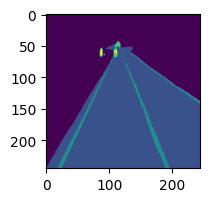

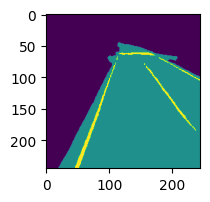

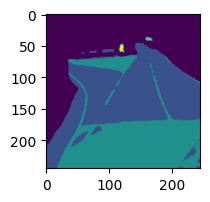

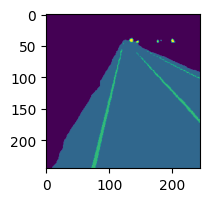

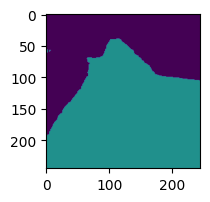

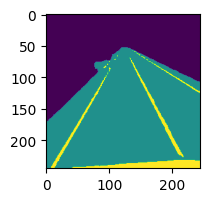

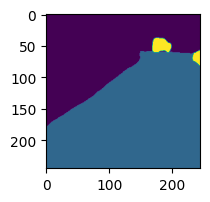

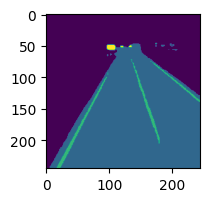

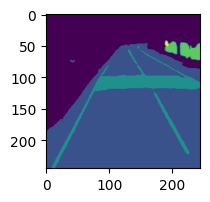

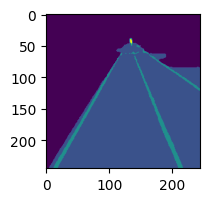

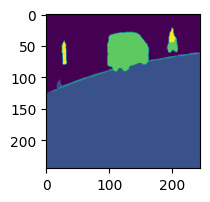

In [218]:
import matplotlib.pyplot as plt

for images, label in train_loader:
    print(image.shape) # (bs,ch,h,w)
    break
    # print(label.shape) 

c=0
for image in images:
    norm_dog = image # np.transpose(image,(0,1,3,2))
    plt.figure(figsize = (2,2))
    plt.imshow(np.transpose(norm_dog, (1,2,0)))
    c=c+1
    if c>10:
        break

In [219]:
images.unique()

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [3]:
from PIL import Image
import numpy as np
pil_img = Image.open('autoencoder/reconstructed/95_0/34.png')


In [10]:
pil_img.size

(245, 245)

In [4]:
np.unique(np.array(pil_img))

array([0, 1, 2], dtype=uint8)

In [7]:
import os 


In [2]:
from my_tools.control import ImageController

In [3]:
controller = ImageController(folder = 'autoencoder/reconstructed/m1',x_shape=245,y_shape=245,max_idx = 100)

no function apply using default function


In [3]:
from seg.seg_hf import HF_mask2Formermodel

seg_model = HF_mask2Formermodel('facebook/mask2former-swin-large-mapillary-vistas-semantic')

/home/lpr/miniconda3/envs/th-cuda11/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using  cuda


/home/lpr/miniconda3/envs/th-cuda11/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


inference time :0.08


In [4]:
import cv2
def vis_seg(**arg):
    img = arg['img']
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return [gray]
    # seg_imgs = seg_model.get_seg_images([gray])
    # return seg_imgs

controller.apply_processor(vis_seg)

In [5]:
controller.run()